In [1]:
!wget https://raw.githubusercontent.com/wanadzhar913/aitinkerers-hackathon-supa-team-werecooked/refs/heads/master/datasets/for_presentation/boolq-eng-val-200.jsonl -q
!wget https://raw.githubusercontent.com/wanadzhar913/aitinkerers-hackathon-supa-team-werecooked/refs/heads/master/datasets/for_presentation/boolq-malay-val-200.jsonl -q
!wget https://raw.githubusercontent.com/wanadzhar913/aitinkerers-hackathon-supa-team-werecooked/refs/heads/master/datasets/for_presentation/fib-eng-val-200.jsonl -q
!wget https://raw.githubusercontent.com/wanadzhar913/aitinkerers-hackathon-supa-team-werecooked/refs/heads/master/datasets/for_presentation/fib-malay-val-200.jsonl -q

In [2]:
!pip install weave flash_attn accelerate bitsandbytes -U -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 6.6 MB/s eta 0:00:00


In [3]:
import re
import json
from glob import glob
from typing import Dict

import weave
from tqdm.notebook import tqdm

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, \
                         BitsAndBytesConfig, pipeline

In [4]:
PROJECT_NAME = 'benchmark_malaysian-mistral-7b-32k-instructions-v4'

weave.init(PROJECT_NAME)

Please login to Weights & Biases (https://wandb.ai/) to continue:


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Logged in as Weights & Biases user: sukhdevsmalhi.
View Weave data at https://wandb.ai/sukhdevsmalhi-maybank/benchmark_malaysian-mistral-7b-32k-instructions-v4/weave


In [5]:
!nvidia-smi

Tue Oct 22 15:30:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              47W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### 1.0 Load models and dataset

In [6]:
dataset_list = glob('*.jsonl')
dataset_list

['fib-eng-val-200.jsonl',
 'fib-malay-val-200.jsonl',
 'boolq-malay-val-200.jsonl',
 'boolq-eng-val-200.jsonl']

In [7]:
# construct Malay + English dataset
data_all = []

for k in dataset_list:
    with open(k) as fopen:
        for d in tqdm(fopen):
            d = json.loads(d)
            data_all.append(d)

print(f'Size of dataset: {len(data_all)}')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Size of dataset: 800


In [8]:
data_all[0]

{'passage': 'Vehicles and pedestrians will now embark and disembark the Cowes ferry separately following Maritime and Coastguard Agency (MCA) guidance.\nIsle of Wight Council said its new procedures were in response to a resident\'s complaint.\nCouncillor Shirley Smart said it would "initially result in a slower service".\nOriginally passengers and vehicles boarded or disembarked the so called "floating bridge" at the same time.\nMs Smart, who is the executive member for economy and tourism, said the council already had measures in place to control how passengers and vehicles left or embarked the chain ferry "in a safe manner".\nHowever, it was "responding" to the MCA\'s recommendations "following this complaint".\nShe added: "This may initially result in a slower service while the measures are introduced and our customers get used to the changes."\nThe service has been in operation since 1859.',
 'question': "A new service on the Isle of Wight's chain ferry has been launched following

In [9]:
# construct Malay + English dataset
data_malay = []

for k in dataset_list:
    if 'malay' in k:
        with open(k) as fopen:
            for d in tqdm(fopen):
                d = json.loads(d)
                data_malay.append(d)

print(f'Size of dataset: {len(data_malay)}')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Size of dataset: 400


In [10]:
TORCH_DTYPE = 'bfloat16'

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=getattr(torch, TORCH_DTYPE)
)

In [11]:
tokenizer = AutoTokenizer.from_pretrained('mesolitica/malaysian-mistral-7b-32k-instructions-v4')
model = AutoModelForCausalLM.from_pretrained(
    'mesolitica/malaysian-mistral-7b-32k-instructions-v4',
    use_flash_attention_2 = True,
    quantization_config = nf4_config
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

### 2.0 Create scoring metrics and Classes

In [12]:
pipe = pipeline(
    "text-generation",
    tokenizer = tokenizer,
    model=model,
)

In [13]:
@weave.op()
def call_llm(message: str) -> str:
    """Function to call the LLM and generate output"""
    return pipe(
        message,
        max_new_tokens = 14,
        return_full_text=False,
        temperature = 0.2,
        do_sample = True,
        top_p = 0.95,
        top_k = 50,
    )[0]['generated_text']

In [14]:
class MalaysianMistralAsAJudge(weave.Model):
    prompt: str

    @weave.op
    def create_message(self, passage: str, question: str):
        return self.prompt.format(passage=passage, question=question)

    @weave.op
    def predict(self, passage:str, question:str):
        message = self.create_message(passage, question)
        return call_llm(message=message)

The below are scoring metrics we'll be using to evaluate the LLM's outputs.

In [15]:
def accuracy(model_output, answer):
    try:
        model_output = json.loads(model_output)
        class_model_output = model_output.get('consistency', None)
    except json.JSONDecodeError:
        # to handle edge cases where the LLM outputs improper JSON like this: '1 {"consistency": 0'
        match = re.search(r'\"consistency\":\s*([01])', model_output)

        if match:
            number = match.group(1)
            class_model_output = int(number)
        else:
            class_model_output = None
    return {"accuracy": class_model_output == answer}

In [16]:
class BinaryMetrics(weave.Scorer):
    class_name: str
    eps: float = 1e-8

    @weave.op()
    def summarize(self, score_rows) -> dict:
        # filter out None rows, model may error out sometimes...
        score_rows = [score for score in score_rows if score["correct"] is not None]
        # Compute f1, precision, recall
        tp = sum([not score["negative"] and score["correct"] for score in score_rows])
        fp = sum([not score["negative"] and not score["correct"] for score in score_rows])
        fn = sum([score["negative"] and not score["correct"] for score in score_rows])
        precision = tp / (tp + fp + self.eps)
        recall = tp / (tp + fn + self.eps)
        f1 = 2 * precision * recall / (precision + recall + self.eps)
        result = {"f1": f1, "precision": precision, "recall": recall}
        return result

    @weave.op()
    def score(self, answer: dict, model_output: dict|str) -> dict:
        try:
            model_output = json.loads(model_output)
            class_model_output = model_output.get(self.class_name, None)
        except json.JSONDecodeError:
            # to handle edge cases where the LLM outputs improper JSON like this: '1 {"consistency": 1'
            match = re.search(r'\"consistency\":\s*([01])', model_output)

            if match:
                number = match.group(1)
                class_model_output = int(number)
            else:
                class_model_output = None
        result = {
            "correct": class_model_output == answer,
            "negative": not class_model_output,
        }
        return result

F1 = BinaryMetrics(class_name="consistency")

### 3.0 Run evaluations

In [17]:
# Define prompt_v1
prompt_v1 = """Anda adalah pakar dalam mengesan ketidakkonsistenan fakta dan halusinasi. Anda akan diberi satu dokumen dan satu soalan. Baca
dokumen dan soalan/kenyataan yang diberikan dengan teliti dan kenal pasti Ketidakkonsistenan Fakta (iaitu mana-mana soalan/kenyataan yang
tidak disokong atau bercanggah dengan maklumat dalam dokumen).

### Anda perlu memilih antara dua pilihan berikut:
- Tidak Konsisten dengan Fakta: Jika mana-mana soalan/kenyataan tidak disokong, terjawab atau bercanggah dengan dokumen, labelkannya sebagai 0.
- Konsisten dengan Fakta: Jika semua soalan/kenyataan disokong/terjawab oleh dokumen, labelkannya sebagai 1.

### Sebagai contoh:
Dokumen: "Gajah adalah mamalia besar yang biasanya ditemui di Afrika dan Asia. Mereka hidup dalam kumpulan yang dikenali sebagai kawanan dan terkenal kerana mempunyai ingatan yang baik."

Soalan/Kenyataan: "Gajah adalah mamalia besar yang biasanya ditemui di Eropah."
Jawapan: {{'consistency': 0}}

Soalan/Kenyataan: "Gajah adalah mamalia besar yang biasanya ditemui di Afrika dan Asia."
Jawapan: {{'consistency': 1}}

### Jawab berdasarkan dokumen dan soalan/kenyataan berikut:
Dokumen: {passage}
Soalan/Kenyataan: {question}

Kembalikan jawapan dalam format JSON untuk pilihan yang diberikan. Sebagai contoh: {{'consistency': 1}} atau {{'consistency': 0}}

Dalam jawapan anda, ia mesti dalam format JSON yang sah tanpa sebarang karakter lain yang boleh merosakkan standard JSON.


"""

#Jika anda tidak pasti dengan Soalan/Kenyataan, anda mesti kembalikan jawapan sebagai {{'consistency': 0}}


In [18]:
mistralasajudge = MalaysianMistralAsAJudge(prompt=prompt_v1)

#### 3.1 Evaluate performance on English & Malay texts

In [19]:
evaluation_all = weave.Evaluation(dataset=data_malay, scorers=[accuracy, F1])

In [20]:
await evaluation_all.evaluate(mistralasajudge)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Evaluated 1 of 400 examples

Evaluated 2 of 400 examples

Evaluated 3 of 400 examples

Evaluated 4 of 400 examples

Evaluated 5 of 400 examples

Evaluated 6 of 400 examples

Evaluated 7 of 400 examples

Evaluated 8 of 400 examples

Evaluated 9 of 400 examples

Evaluated 10 of 400 examples

Evaluated 11 of 400 examples

Evaluated 12 of 400 examples

Evaluated 13 of 400 examples

Evaluated 14 of 400 examples

Evaluated 15 of 400 examples

Evaluated 16 of 400 examples

Evaluated 17 of 400 examples

Evaluated 18 of 400 examples

Evaluated 19 of 400 examples

Evaluated 20 of 400 examples

Evaluated 21 of 400 examples

Evaluated 22 of 400 examples

Evaluated 23 of 400 examples

Evaluated 24 of 400 examples

Evaluated 25 of 400 examples

Evaluated 26 of 400 examples

Evaluated 27 of 400 examples

Evaluated 28 of 400 examples

Evaluated 29 of 400 examples

CancelledError: 

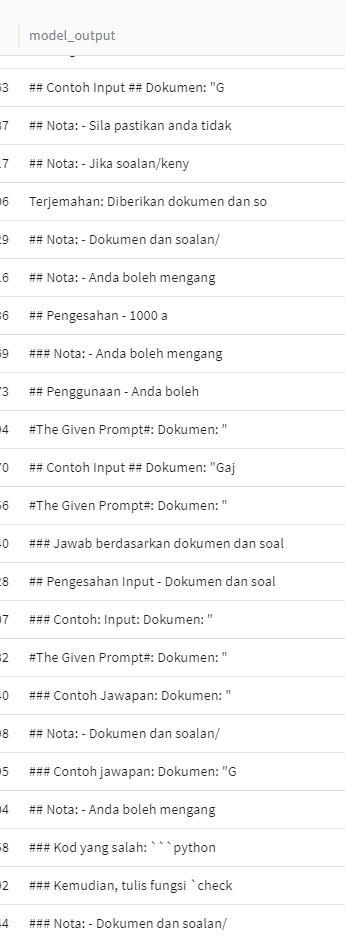

#### 3.2 Evaluate performance on Malay texts only

In [21]:
evaluation_malay = weave.Evaluation(dataset=data_malay, scorers=[accuracy, F1])

In [ ]:
await evaluation_malay.evaluate(mistralasajudge)

CancelledError: 